# Bias Mitigation Experiments - COMPAS

## Table of Contents

<!-- To return to the table of contents, click on the number at any major section heading.

* [1. Prepare COMPAS data](#1.-Prepare-COMPAS-data)

* [2. Training Baseline Models](#2.-Training-Baseline-Models)
    * [2.1 Logistic Regression](#2.1-Learning-a-Logistic-Regression-(LR)-classifier-on-original-data)
    * [2.2 Random Forest](#2.2-Learning-a-Random-Forest-(RF)-classifier-on-original-data)

* [3. Bias mitigation using pre-processing technique](#3.-Bias-mitigation-using-pre-processing-technique)

   * [3.1 Reweighing](#3.1-Reweighing)
       * [3.1.1 RW on Logistic Regression](#3.1.1.-Learning-a-Logistic-Regression-(LR)-classifier-on-data-transformed-by-reweighing)
       * [3.1.2 RW on Random Forest](#3.1.2.-Learning-a-Random-Forest-(RF)-classifier-on-data-transformed-by-reweighing)
   * [3.2 Disparate impact remover ](#3.2-Disparate-impact-remover)
       * [3.2.1 DIR on Logistic Regression](#3.2.1-Learning-a-Logistic-Regression-(LR)-classifier-on-data-transformed-by-DIR)
       * [3.2.2 DIR on Random Forest](#3.2.2-Learning-a-Random-Forest-(RF)-classifier-on-data-transformed-by-DIR)
  
* [4. Bias mitigation using in-processing technique](#4.-Bias-mitigation-using-in-processing-technique)
    * [4.1 Prejudice Remover (PR)](#4.1-Prejudice-Remover-(PR))
    * [4.2 Adversarial Debiasing](#4.2-Adversarial-Debiasing)

* [5. Bias mitigation using post-processing technique](#5.-Bias-mitigation-using-post-processing-technique)
    * [5.1 Reject option classification (ROC)](#5.1-Reject-option-classification-(RejOpCl))
        * [5.1.1 ROC on Logistic Regression](#5.1.1-Reject-option-classification-on-Logistic-Regression)
        * [5.1.2 ROC on Random Forest](#5.1.2-Reject-option-classification-on-Random-Forest)
    * [5.2 Equalized odds processor (EOPP)](#5.2-Equalized-odds-processor-(EqOddsPr))
        * [5.2.1 EOPP on Logistic Regression](#5.2.1-Equalized-odds-processor-on-Logistic-Regression)
        * [5.2.2 EOPP on Random Forest](#5.2.2-Equalized-odds-processor-on-Random-Forest)

* [6. Summary of results](#6.-Summary-of-Model-Learning-Results)

* [7. Analyze rates of different mitigators](#7.-Analyze-rates-of-different-mitigators)

 -->

In [1]:
# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import helperfunctions as helpers
%load_ext autoreload
%autoreload 2
# allow automatic reloading of changes in helperfile

In [3]:
# Standard packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
import seaborn as sns
import random
from tqdm import tqdm
from numpy import mean
from numpy import std
from IPython.display import Markdown, display

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Sklearn
# from sklearn.cluster import KMeans
# from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
## accuracy metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import recall_score, precision_score # for fairness metrics (calculate diff)
## base estimators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import difference as aif_difference
# from aif360.sklearn.metrics import specificity_score, false_omission_rate_error
from aif360.sklearn.metrics import specificity_score
from aif360.sklearn.metrics import statistical_parity_difference, average_odds_difference, \
                                   equal_opportunity_difference, average_odds_error
from aif360.sklearn.metrics import disparate_impact_ratio

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
# from aif360.algorithms.preprocessing import Reweighing
# from aif360.algorithms.preprocessing import OptimPreproc
# from aif360.algorithms.preprocessing import DisparateImpactRemover
# from aif360.algorithms.preprocessing import LFR
from aif360.sklearn.preprocessing import ReweighingMeta, LearnedFairRepresentations
from aif360.sklearn.inprocessing import AdversarialDebiasing, ExponentiatedGradientReduction
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, RejectOptionClassifier


# Set plot font
plt.rcParams.update({'font.family':'serif'})
plt.rcParams.update({'font.serif':'Times New Roman'})

pip install 'aif360[FairAdapt]'


## [1.](#Table-of-Contents) Prepare COMPAS data

In [4]:
# read in data as pandas data frame
df = pd.read_csv("../data/Compas/compas-scores-two-years.csv")
# check columns
pd.set_option('display.max_columns', None) # expand all columns
df.head()

id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  juv_fel_count  \
0  1947-04-18   69  Greater than 45             Other              0   
1  1982-01-22   34          25 - 45  African-American              0   
2  1991-05-14   24     Less than 25  African-American              0   
3  1993-01-21   23     Less than 25  African-American              0   
4  1973-01-22   43          25 - 45             Other              0   

   decile_score  juv_misd_count  juv_other_count  priors_count  \
0             1               0                0             0   
1             3               0                0             0   
2             4               0                1             4   
3             8               1                0             1   
4             1               0                0             2   

   days_b_screening_arrest            c_jail_in           c_jail_out  \
0                     -1.0  2013-08-13 06:03:42  2013-08-14 05:41:20   
1                     -1.0  2013-01-26 03:45:27  2013-02-05 05:36:53   
2                     -1.0  2013-04-13 04:58:34  2013-04-14 07:02:04   
3                      NaN                  NaN                  NaN   
4                      NaN                  NaN                  NaN   

   c_case_number c_offense_date c_arrest_date  c_days_from_compas  \
0  13011352CF10A     2013-08-13           NaN                 1.0   
1  13001275CF10A     2013-01-26           NaN                 1.0   
2  13005330CF10A     2013-04-13           NaN                 1.0   
3  13000570CF10A     2013-01-12           NaN                 1.0   
4  12014130CF10A            NaN    2013-01-09                76.0   

  c_charge_degree                   c_charge_desc  is_recid  r_case_number  \
0               F    Aggravated Assault w/Firearm         0            NaN   
1               F  Felony Battery w/Prior Convict         1  13009779CF10A   
2               F           Possession of Cocaine         1  13011511MM10A   
3               F          Possession of Cannabis         0            NaN   
4               F           arrest case no charge         0            NaN   

  r_charge_degree  r_days_from_arrest r_offense_date  \
0             NaN                 NaN            NaN   
1            (F3)                 NaN     2013-07-05   
2            (M1)                 0.0     2013-06-16   
3             NaN                 NaN            NaN   
4             NaN                 NaN            NaN   

                 r_charge_desc   r_jail_in  r_jail_out  violent_recid  \
0                          NaN         NaN         NaN            NaN   
1  Felony Battery (Dom Strang)         NaN         NaN            NaN   
2  Driving Under The Influence  2013-06-16  2013-06-16            NaN   
3                          NaN         NaN         NaN            NaN   
4                          NaN         NaN         NaN            NaN   

   is_violent_recid vr_case_number vr_charge_degree vr_offense_date  \
0                 0            NaN              NaN             NaN   
1                 1  13009779CF10A             (F3)      2013-07-05   
2                 0            NaN              NaN             NaN   
3                 0            NaN              NaN             NaN   
4                 0            NaN              NaN             NaN   

                vr_charge_desc  type_of_assessment  decile_score.1 score_text  \
0                          NaN  Risk of Recidivism               1        Low   
1  Felony Battery (Dom

In [5]:
# select features of interest
df = df[['sex','age','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','c_charge_degree', 'two_year_recid']]

# unique values of the protected feature race
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [6]:
# encode protected features 

# make race (=protected attribute) a binary variable
array = ['Caucasian', 'African-American'] # only include samples corresponding to Caucasian or African-American
df = df.loc[df['race'].isin(array)]

def protected_race(row):
    if row['race'] == 'Caucasian': # Caucasian is the privileged group in this case
        value = 1
    else:
        value = 0
    return value

df['race'] = df.apply(protected_race, axis=1)

# make sex a binary variable
def protected_sex(row):
    if row['sex'] == 'Female': # female is the privileged group in this case
        value = 1
    else:
        value = 0
    return value

df['sex'] = df.apply(protected_sex, axis=1)

In [7]:
# # one hot encoding of object features
# categorical_cols = list(df.select_dtypes(exclude=[np.number]).columns)
# df = pd.get_dummies(df, columns = categorical_cols)

# # encode binary feature: c_charge 
# df = df.drop(['c_charge_degree_F'], axis=1)
# reset index
df = df.reset_index(drop=True)

In [8]:
# flip labels to ensure pos_label = 1, not becoming recidivist
df['two_year_recid'] = (~df['two_year_recid'].astype(bool)).astype(int)

# select descriptive features and target variable
X = df.loc[:, df.columns != 'two_year_recid'] # select all features but target feature
y = df[['race', 'two_year_recid']] # include protected feature in order to AIF360

In [9]:
# set protected attribute as index
X = X.set_index(['race'], append = True, drop = False)
y = y.set_index(['race'], append = True)

# make y data frames to 1d array to pass modeling, but keep index (protected attribute)
y = pd.Series(y['two_year_recid'], index=y.index)

In [10]:
pos_label = 1
priv_group = 1

## [2.](#Table-of-Contents) Proposed GridSearch Approach 

The GridSearch Approach includes hyperparameter, threshold, and Bias Mitigation

In [11]:
# taken from AIF360/aif360/sklearn/metrics/metrics.py due to import error
from sklearn.metrics._classification import _prf_divide, _check_zero_division
from sklearn.metrics import multilabel_confusion_matrix
def false_omission_rate_error(y_true, y_pred, *, pos_label=1, sample_weight=None,
                      zero_division='warn'):
    """Compute the false omission rate.
    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated targets as returned by a classifier.
        pos_label (scalar, optional): The label of the positive class.
        sample_weight (array-like, optional): Sample weights.
        zero_division ('warn', 0 or 1): Sets the value to return when there is a
            zero division. If set to “warn”, this acts as 0, but warnings are
            also raised.
    """
    _check_zero_division(zero_division)
    MCM = multilabel_confusion_matrix(y_true, y_pred, labels=[pos_label],
                                      sample_weight=sample_weight)
    tn, fn = MCM[:, 0, 0], MCM[:, 1, 0]
    negs = tn + fn
    return _prf_divide(fn, negs, 'false omission rate', 'predicted negative', None,
                       ('false omission rate',), zero_division).item()

In [12]:
def store_metrics(y_test, y_pred, pred_prob, thres_dict, threshold, priv_group, pos_label):
    """Returns a dictionary with all interested accuracy and fairness metrics.
        Args:
            y_test (array-like): true labels from test set.
            y_pred (array-like): predicted labels for test set.
            thres_dict (dict): dictionary that stores all info.
            threshold (np.float): given threshold used to obtain y_pred.
        Returns:
            dict: `thres_dict`
    """
    # evaluate model performance for each split
    thres_dict[threshold]['acc_score'] += [accuracy_score(y_test, y_pred)]
    thres_dict[threshold]['bacc_score'] += [balanced_accuracy_score(y_test, y_pred)]
    thres_dict[threshold]['f1_score'] += [f1_score(y_test, y_pred)]
    thres_dict[threshold]['auc_score'] += [roc_auc_score(y_test, pred_prob)]
    thres_dict[threshold]['mcc_score'] += [matthews_corrcoef(y_test, y_pred)]
    thres_dict[threshold]['norm_mcc_score'] += [0.5*(matthews_corrcoef(y_test, y_pred)+1)]
    
    thres_dict[threshold]['spd_score'] += [statistical_parity_difference(y_test, y_pred, prot_attr='race',
                                                                         priv_group=priv_group, pos_label=pos_label)]
    thres_dict[threshold]['aod_score'] += [average_odds_difference(y_test, y_pred, prot_attr='race',
                                                                   priv_group=priv_group, pos_label=pos_label)]
    thres_dict[threshold]['eod_score'] += [equal_opportunity_difference(y_test, y_pred, prot_attr='race',
                                                                        priv_group=priv_group, pos_label=pos_label)]
    thres_dict[threshold]['ford_score'] += [aif_difference(false_omission_rate_error, y_test, y_pred,
                                                          prot_attr='race', priv_group=priv_group, pos_label=pos_label)]
    thres_dict[threshold]['ppvd_score'] += [aif_difference(precision_score, y_test, y_pred, prot_attr='race',
                                                          priv_group=priv_group, pos_label=pos_label)]


    aif_difference

    return thres_dict

def get_avg_metrics(thres_dict):
    """Returns the average of all cv splits from the same model setting (hyperparameter and threshold).
    Args:
        thres_dict (dict): the dictionary with all info on each cv split.
    Returns:
        dict: `final_metrics`
    """ 
    import copy
    # calculate the average for each metrics from all splits
    avg_metrics = copy.deepcopy(thres_dict)
    for threshold in avg_metrics.keys(): 
        average_list = {}
        for metric in avg_metrics[threshold].keys():
            average_list['avg_%s'%metric] = mean(avg_metrics[threshold][metric])
        avg_metrics[threshold]['average'] = average_list
    return avg_metrics

def get_output_table(all_metrics, base, scoring):
    """Returns the output table from all param_grid.
    Args:
        all_metrics (dict): the final dictionary with info from all param_grid.
        base (str): the name of the base estimator that is shown in the output table.
    """ 

    output_table = pd.DataFrame()
    for model in all_metrics.keys():
        all_metrics[model]['parameters']['hparam'].pop('random_state', None)
        table_cv = pd.DataFrame(all_metrics[model]['metrics']['average'], index=[0])
        table_cv.insert(0, 'base_estimator', base)
        table_cv.insert(1, 'param', str(all_metrics[model]['parameters']['hparam']))
        table_cv.insert(2, 'Bias_Mitigation', str(all_metrics[model]['parameters']['Bias_Mitigation']))
        table_cv.insert(3, 'threshold', all_metrics[model]['parameters']['threshold'])
        # table_cv[table_cv.Bias_Mitigation.isin(['AD']),['model','param']] = None
        table_cv[['model','param']] = np.where(table_cv['Bias_Mitigation'].isin(['AD']), '', table_cv[['model','param']])
        output_table = pd.concat([output_table, table_cv]).reset_index(drop=True)
        
    # output_table.Bias_Mitigation = output_table.Bias_Mitigation.replace({'no_BM':''})
    
    # find "best" model
    acc_metric = 'avg_'+scoring[0].lower()+'_score'
    fair_metric = 'avg_'+scoring[1].lower()+'_score'
    w_acc = scoring[2]
    w_fair = scoring[3]

    output_table['cost'] = w_acc*(1-output_table[acc_metric]) + w_fair*(output_table[fair_metric])


    return output_table

def style_table(df):
    """Returs the output table with highlight on the best metrics
    Args:
        df (DataFrame): the output table to be styled
    """
    accuracy_metrics = ['avg_'+col for col in ['acc_score', 'bacc_score', 'f1_score', 'auc_score', 'mcc_score','norm_mcc_score']]
    fairness_metrics = ['avg_'+col for col in ['spd_score', 'aod_score', 'eod_score','ford_score','ppvd_score']]

    best_index = np.argmin(df.cost)
    df = df.style.highlight_max(subset=accuracy_metrics,color='lightgreen')\
                   .apply(lambda s:['background: yellow' if abs(cell)==min(abs(s)) else '' for cell in s], subset=fairness_metrics)\
                   .highlight_min(subset=['cost'],color='lightblue')\
                   .apply(lambda s:['font-weight: bold' if v == s.iloc[best_index] else '' for v in s])
    
    return df

In [13]:
# # logistic regression classifier with stratified kfold cross validation
# cv=10
# random_state=1234
# skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
#     y_train , y_test = y[train_index] , y[test_index]
#     # normalize data features, fit on training set to avoid data leakage
#     scaler = StandardScaler()
#     scaler.fit(X_train[X_train.columns])
#     X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
#     X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])


In [14]:
# X_train.to_pickle("X_train")
# X_test.to_pickle("X_test")
# y_train.to_pickle("y_train")
# y_test.to_pickle("y_test")

In [15]:
class skf_model():
    """
    stratified k-fold model class, to implement the grid-search framework 
    with k-fold to ensure performance stability.
    """
    def __init__(self, pos_label, priv_group, cv, random_state):
        self.pos_label = pos_label
        self.priv_group = priv_group
        self.cv = cv
        self.random_state = random_state
        
    # @methods
    def get_metrics(self, X, y, base='LR', param = {}, BM_arr=[None], thres_arr=[0.5]):
        # logistic regression classifier with stratified kfold cross validation
        skf = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)
        thres_dict = {threshold: {'acc_score':[], 'bacc_score': [], 'f1_score': [], 'auc_score': [],
                                  'mcc_score': [],'norm_mcc_score': [],
                                  'spd_score': [], 'aod_score': [], 'eod_score': [],'ford_score': [],'ppvd_score': []}\
                      for threshold in thres_arr}
        thres_BM_dict = {}
        
        for train_index, test_index in skf.split(X, y):
            categorical_cols = list(X.select_dtypes(exclude=[np.number]).columns)
            X = pd.get_dummies(X, columns = categorical_cols)

            X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
            y_train , y_test = y[train_index] , y[test_index]

            # normalize data features, fit on training set to avoid data leakage
            scaler = StandardScaler()
            scaler.fit(X_train[X_train.columns])
            X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
            X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

            # fit model
            if base!='NB':
                param.update({'random_state': self.random_state})
            else: pass
        
            if base=='LR':
                base_estimator=LogisticRegression(**param)
            elif base=='RF':
                base_estimator=RandomForestClassifier(**param)
            elif base=='GB':
                base_estimator=GradientBoostingClassifier(**param)
            elif base=='SVM':
                param.update({'probability':True})
                base_estimator=SVC(**param)
            elif base=='NB':
                base_estimator=GaussianNB(**param)
 
            BM_dict = {None: base_estimator, 
                       # pre-processing
                       'RW': ReweighingMeta(estimator=base_estimator), 
                       'LFR': LearnedFairRepresentations(prot_attr='race', random_state=self.random_state),
                       # in-processing
                       'AD': AdversarialDebiasing(prot_attr='race', random_state=self.random_state),
                       'EGR': ExponentiatedGradientReduction(prot_attr='race', estimator=base_estimator,
                                                             constraints="EqualizedOdds"),
                       # post-processing
                       'ROC': base_estimator,
                       'CEO': base_estimator} 
    
            for BM in BM_arr:
                BM_name = 'None' if BM == None else BM
                model = BM_dict[BM]
                if BM=='LFR':
                    model.fit(X_train,y_train,priv_group=self.priv_group)
                else: model.fit(X_train,y_train)
                
                pred_prob_all = model.predict_proba(X_test)
                pred_prob = pred_prob_all[:,1]

                for threshold in thres_arr:
                    y_pred = (pred_prob >= threshold).astype('int') # set threshold
                    if BM !='ROC':
                        thres_dict = store_metrics(y_test, y_pred, pred_prob, thres_dict, threshold,
                                                   self.priv_group, self.pos_label)
                    else: # Post-Processing
                        if BM=='ROC':
                            # fit the primary prediction to post-processing models  
                            post_model = RejectOptionClassifier(prot_attr='race',threshold=threshold)
                            post_model.fit(pred_prob,y_test,pos_label=self.pos_label,priv_group=self.priv_group)
                        elif BM=='CEO':
                            post_model = CalibratedEqualizedOdds(prot_attr='race',random_state=self.ramdom_state)
                            post_model.fit(pred_prob,y_test,pos_label=self.pos_label)                            
                        # get final prediction
                        intial_pred = pd.DataFrame(pred_prob_all, index=X_test.index)
                        final_pred_prob = post_model.predict_proba(intial_pred)[:,1]
                        final_y_pred = (final_pred_prob >= threshold).astype('int') # set threshold
                        thres_dict = store_metrics(y_test, final_y_pred, final_pred_prob, thres_dict, threshold,
                                                   self.priv_group, self.pos_label)
                avg_metrics = get_avg_metrics(thres_dict)
                thres_BM_dict[BM_name] = avg_metrics

        return thres_BM_dict

In [22]:
class fair_GridsearchCV():
    def __init__(self, base, param_grid, pos_label, priv_group, cv=10, random_state=1234):
        """
        base (string): base estimator, e.g. "LR", "RF", "GB", "SVM", "NB", "TabTr"
        """
        self.base = base
        self.param_grid = param_grid
        self.pos_label = pos_label
        self.priv_group = priv_group
        self.cv = cv
        self.random_state = random_state
        

    def fit(self, X=X, y=y,scoring=('norm_mcc','spd',1,1), random_state=1234):
        """Run fit with all sets of parameters.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples, n_output) \
            or (n_samples,), default=None
            Target relative to X for classification or regression;
            None for unsupervised learning.
        scoring : tuple, default=('MCC','SPD',1,1)
                  1st element stands for the chosen accuracy metric;
                  2nd element stands for the chosen fairness metric;
                  3rd element stands for alpha value, that is, the weight on accuray cost;
                  4th element stands for beta value, that is, the weight on fairness cost;
                  
                  References:
                  Haas, Christian. "The price of fairness-A framework to explore trade-offs in algorithmic fairness." 
                  40th International Conference on Information Systems, ICIS 2019. Association for Information Systems, 2019.

        Returns
        -------
        self : object
            Instance of fitted estimator.
        """
        # default setting if hyper-parameters not specified
        default_hyperp_dict = {'LR': [{'penalty':'l2'}],
                               'RF': [{'n_estimators':'100','criterion':'gini'}],
                               'GB': [{'learning_rate':0.1,'criterion':'friedman_mse'}],
                               'SVM':[{'C':1,'kernel':'rbf','gamma':'scale'}],
                               'NB': [{'var_smoothing': 1e-9}]}
        if 'hyperp_grid' in self.param_grid: 
            hyperp_grid = list(ParameterGrid(param_grid['hyperp_grid']))
        else: hyperp_grid = default_hyperp_dict[self.base]  
        if 'Bias_Mitigation' not in self.param_grid: 
            param_grid['Bias_Mitigation'] = [None]        
        if 'threshold' not in self.param_grid: 
            param_grid['threshold'] = [0.5]

        all_metrics = {}
        for i, param in enumerate(tqdm(hyperp_grid)):
            print(param)
            model = skf_model(self.pos_label, self.priv_group, self.cv, self.random_state)
            metrics = model.get_metrics(X=X, y=y, base=self.base, param=param, 
                                        BM_arr=param_grid['Bias_Mitigation'], thres_arr=param_grid['threshold'])
            # print(metrics)
            for j, BM in enumerate(metrics.keys()):
                for k,thres in enumerate(metrics[BM].keys()):
                    all_param = {'hparam':param, 'Bias_Mitigation':BM, 'threshold':thres}
                    all_metrics['%s_%s%s%s'%(self.base,i,j,k)] = {'parameters':all_param, 'metrics':metrics[BM][thres]}
                    
        self.all_metrics = all_metrics
        self.output_table = get_output_table(all_metrics, base=self.base, scoring=scoring)

        # "best" model
        param_col = ['model','param','Bias_Mitigation','threshold']
        self._best_index = np.argmin(self.output_table.cost)
        self._best_param = self.output_table.loc[self._best_index, param_col]

        return self

In [17]:
param_grid = {'hyperp_grid': {'C':[1, 10],'solver':['liblinear', 'saga'],'penalty':['l1','l2']}, 
              'threshold': np.linspace(0.3, 0.7, 7),
              'Bias_Mitigation':[None,'RW','LFR','AD','EGR','ROC','CEO']}
# param_grid = {'hyperp_grid': {'C':[0.1, 1]},
#               'threshold': np.linspace(0.3, 0.7, 11),
#               'Bias_Mitigation':[None,'CEO']}
clf_LR = fair_GridsearchCV(base='LR',param_grid=param_grid, pos_label=pos_label, priv_group=priv_group)
clf_LR.fit(X=X, y=y)
results_LR = clf_LR.output_table
print(clf_LR._best_param)
style_table(results_LR)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Metal device set to: Apple M1 Pro


2023-01-21 03:04:28.913446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:04:28.914009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:04:29.071999: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-21 03:04:29.079808: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-21 03:04:29.086086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:04:29.212308: I tensorflow/core/grappler/optimizers/custom_graph

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


2023-01-21 03:08:54.218528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:08:54.218552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:08:54.357872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:08:54.389462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:09:14.233561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:09:21.36

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


2023-01-21 03:13:21.390376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:13:21.390396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:13:21.526493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:13:21.564113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:13:40.137057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:13:47.30

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}


2023-01-21 03:17:45.881821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:17:45.881848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:17:46.010232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:17:46.047711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:18:04.493407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:18:11.65

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


2023-01-21 03:22:08.273780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:22:08.273805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:22:08.401784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:22:08.440064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:22:26.892215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:22:35.94

{'C': 10, 'penalty': 'l1', 'solver': 'saga'}


2023-01-21 03:27:01.121197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:27:01.121262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:27:01.266373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:27:01.316343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:27:21.712705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:27:29.15

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


2023-01-21 03:31:35.133276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:31:35.133305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:31:35.266708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:31:35.314908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:31:54.650761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:32:01.96

{'C': 10, 'penalty': 'l2', 'solver': 'saga'}


2023-01-21 03:36:06.677668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 03:36:06.677701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-21 03:36:06.910751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:36:07.026122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:36:27.134593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-21 03:36:34.35

model                                                            LR
param              {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Bias_Mitigation                                                  RW
threshold                                                       0.5
Name: 108, dtype: object


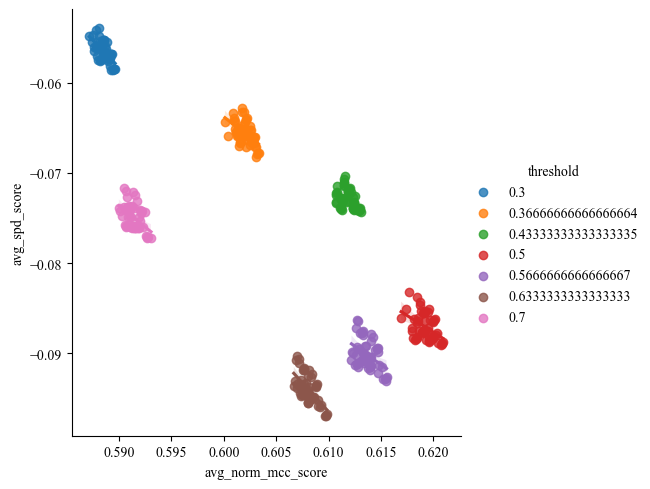

In [58]:
# import matplotlib.pyplot as plt
# results_LR.plot(x="avg_norm_mcc_score", y="avg_spd_score", kind="scatter")
# plt.show()
g = sns.lmplot(data=results_LR, x="avg_norm_mcc_score", y="avg_spd_score", hue="threshold")

In [19]:
param_grid = {'hyperp_grid': {'n_estimators':[10, 100],'criterion':['gini', 'entropy'], 'max_depth':[8, None]}, 
              'threshold': np.linspace(0.3, 0.7, 7),
              'Bias_Mitigation':[None,'RW','LFR','ROC','CEO']}
# param_grid = {'hyperp_grid': {'n_estimators':[10, 100]},
#               'threshold': np.linspace(0.3, 0.7, 11),
#               'Bias_Mitigation':[None,'ROC','CEO']}
clf_RF = fair_GridsearchCV(base='RF',param_grid=param_grid, pos_label=pos_label, priv_group=priv_group)
clf_RF.fit(X=X, y=y)
results_RF = clf_RF.output_table
print(clf_RF._best_param)
style_table(results_RF)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 10}


 12%|█████▋                                       | 1/8 [00:48<05:42, 48.98s/it]

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}


 25%|███████████▎                                 | 2/8 [01:43<05:13, 52.18s/it]

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 10}


 38%|████████████████▉                            | 3/8 [02:32<04:14, 50.88s/it]

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


 50%|██████████████████████▌                      | 4/8 [03:31<03:35, 53.81s/it]

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 10}


 62%|████████████████████████████▏                | 5/8 [04:19<02:36, 52.03s/it]

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}


 75%|█████████████████████████████████▊           | 6/8 [05:14<01:45, 52.82s/it]

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 10}


 88%|███████████████████████████████████████▍     | 7/8 [06:03<00:51, 51.59s/it]

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}


100%|█████████████████████████████████████████████| 8/8 [07:02<00:00, 52.80s/it]


model                                                             RF
param              {'criterion': 'entropy', 'max_depth': 8, 'n_es...
Bias_Mitigation                                                   RW
threshold                                                        0.5
Name: 185, dtype: object


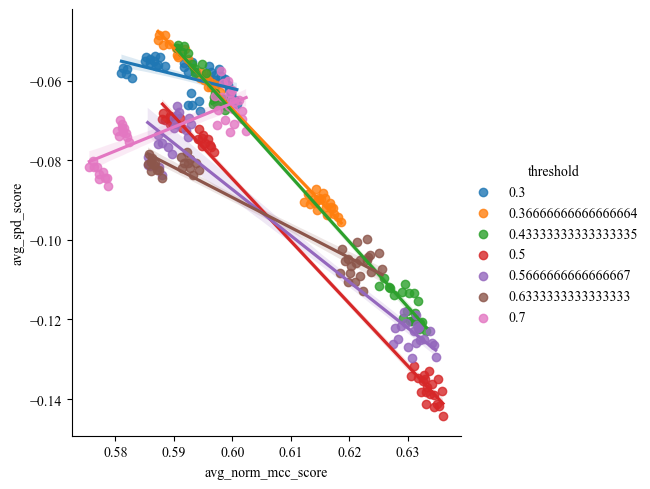

In [59]:
# import matplotlib.pyplot as plt
# results_RF.plot(x="avg_norm_mcc_score", y="avg_spd_score", kind="scatter")
# plt.show()
g = sns.lmplot(data=results_RF, x="avg_norm_mcc_score", y="avg_spd_score", hue="threshold")

In [23]:
param_grid = {'hyperp_grid': {'n_estimators':[10, 100],'criterion':['friedman_mse', 'squared_error'], 'max_depth':[8, None]}, 
              'threshold': np.linspace(0.3, 0.7, 7),
              'Bias_Mitigation':[None,'RW','LFR','ROC','CEO']}
# param_grid = {'hyperp_grid': {'learning_rate':[0.1, 0.01, 0.001]},
#               'threshold': np.linspace(0.3, 0.7, 11),
#               'Bias_Mitigation':[None,'CEO']}
clf_GB = fair_GridsearchCV(base='GB',param_grid=param_grid, pos_label=pos_label, priv_group=priv_group)
clf_GB.fit(X=X, y=y)
results_GB = clf_GB.output_table
print(clf_GB._best_param)
style_table(results_GB)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

{'criterion': 'friedman_mse', 'max_depth': 8, 'n_estimators': 10}


 12%|█████▋                                       | 1/8 [00:53<06:14, 53.52s/it]

{'criterion': 'friedman_mse', 'max_depth': 8, 'n_estimators': 100}


 25%|███████████▎                                 | 2/8 [02:07<06:32, 65.39s/it]

{'criterion': 'friedman_mse', 'max_depth': None, 'n_estimators': 10}


 38%|████████████████▉                            | 3/8 [03:06<05:13, 62.68s/it]

{'criterion': 'friedman_mse', 'max_depth': None, 'n_estimators': 100}


 50%|██████████████████████▌                      | 4/8 [05:30<06:18, 94.57s/it]

{'criterion': 'squared_error', 'max_depth': 8, 'n_estimators': 10}


 62%|████████████████████████████▏                | 5/8 [06:21<03:57, 79.05s/it]

{'criterion': 'squared_error', 'max_depth': 8, 'n_estimators': 100}


 75%|█████████████████████████████████▊           | 6/8 [07:32<02:32, 76.27s/it]

{'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 10}


 88%|███████████████████████████████████████▍     | 7/8 [08:31<01:10, 70.76s/it]

{'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 100}


100%|█████████████████████████████████████████████| 8/8 [10:57<00:00, 82.17s/it]


model                                                             GB
param              {'criterion': 'squared_error', 'max_depth': 8,...
Bias_Mitigation                                                   RW
threshold                                                   0.433333
Name: 184, dtype: object


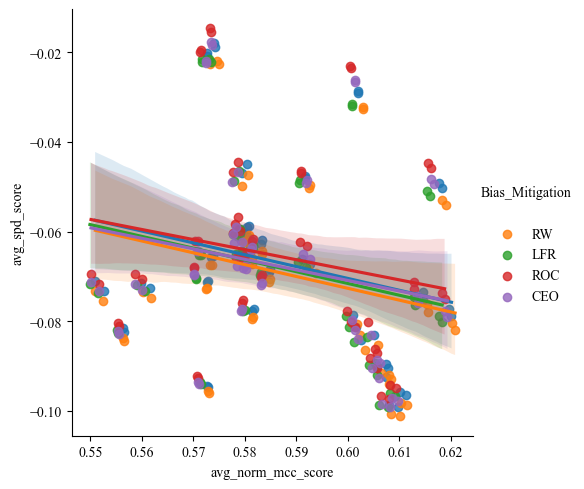

In [61]:
# import matplotlib.pyplot as plt
# results_GB.plot(x="avg_norm_mcc_score", y="avg_spd_score", kind="scatter")
# plt.show()
g = sns.lmplot(data=results_GB, x="avg_norm_mcc_score", y="avg_spd_score", hue="Bias_Mitigation")

In [26]:
param_grid = {'hyperp_grid': {'kernel':['rbf','linear','poly','sigmoid']},
              'threshold': np.linspace(0.3, 0.7, 7),
              'Bias_Mitigation':[None,'RW','LFR','ROC','CEO']}
# param_grid = {'hyperp_grid': {'kernel':['rbf','linear']},
#               'threshold': np.linspace(0.3, 0.7, 11),
#               'Bias_Mitigation':[None,'CEO']}
clf_SVM = fair_GridsearchCV(base='SVM',param_grid=param_grid, pos_label=pos_label, priv_group=priv_group)
clf_SVM.fit(X=X, y=y)
results_SVM = clf_SVM.output_table
print(clf_SVM._best_param)
style_table(results_SVM)

  0%|                                                     | 0/4 [00:00<?, ?it/s]

{'kernel': 'rbf'}


 25%|███████████                                 | 1/4 [02:51<08:33, 171.23s/it]

{'kernel': 'linear'}


 50%|██████████████████████                      | 2/4 [05:15<05:10, 155.10s/it]

{'kernel': 'poly'}


 75%|█████████████████████████████████           | 3/4 [07:52<02:36, 156.35s/it]

{'kernel': 'sigmoid'}


100%|████████████████████████████████████████████| 4/4 [10:47<00:00, 161.82s/it]


model                                                 SVM
param              {'kernel': 'rbf', 'probability': True}
Bias_Mitigation                                        RW
threshold                                        0.566667
Name: 11, dtype: object


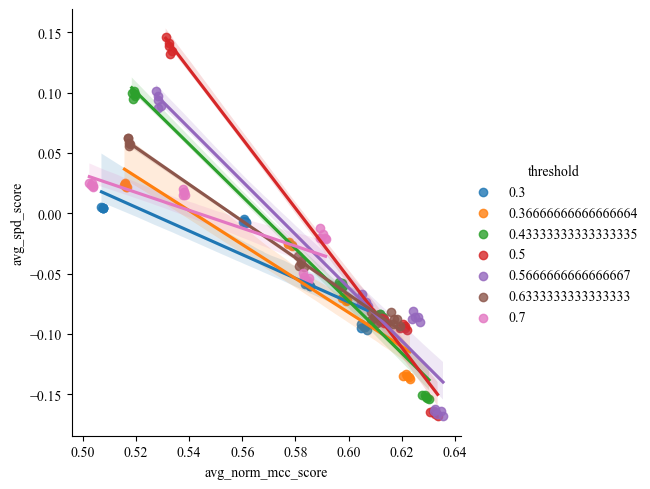

In [64]:
# import matplotlib.pyplot as plt
# results_SVM.plot(x="avg_norm_mcc_score", y="avg_spd_score", kind="scatter")
# plt.show()
g = sns.lmplot(data=results_SVM, x="avg_norm_mcc_score", y="avg_spd_score", hue="threshold")

In [29]:
param_grid = {'hyperp_grid': {'var_smoothing': np.logspace(0,-9, num=5)}, 
              'threshold': np.linspace(0.3, 0.7, 7),
              'Bias_Mitigation':[None,'RW','LFR','ROC','CEO']}
# param_grid = {'hyperp_grid': {'var_smoothing': np.logspace(0,-9, num=2)},
#               'threshold': np.linspace(0.3, 0.7, 11),
#               'Bias_Mitigation':[None,'CEO']}
clf_NB = fair_GridsearchCV(base='NB',param_grid=param_grid, pos_label=pos_label, priv_group=priv_group)
clf_NB.fit(X=X, y=y)
results_NB = clf_NB.output_table
print(clf_NB._best_param)
style_table(results_NB)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

{'var_smoothing': 1.0}


 20%|█████████                                    | 1/5 [00:49<03:19, 49.86s/it]

{'var_smoothing': 0.005623413251903491}


 40%|██████████████████                           | 2/5 [01:38<02:27, 49.22s/it]

{'var_smoothing': 3.1622776601683795e-05}


 60%|███████████████████████████                  | 3/5 [02:27<01:38, 49.06s/it]

{'var_smoothing': 1.7782794100389227e-07}


 80%|████████████████████████████████████         | 4/5 [03:16<00:48, 48.99s/it]

{'var_smoothing': 1e-09}


100%|█████████████████████████████████████████████| 5/5 [04:05<00:00, 49.08s/it]


model                                  NB
param              {'var_smoothing': 1.0}
Bias_Mitigation                        RW
threshold                             0.7
Name: 13, dtype: object


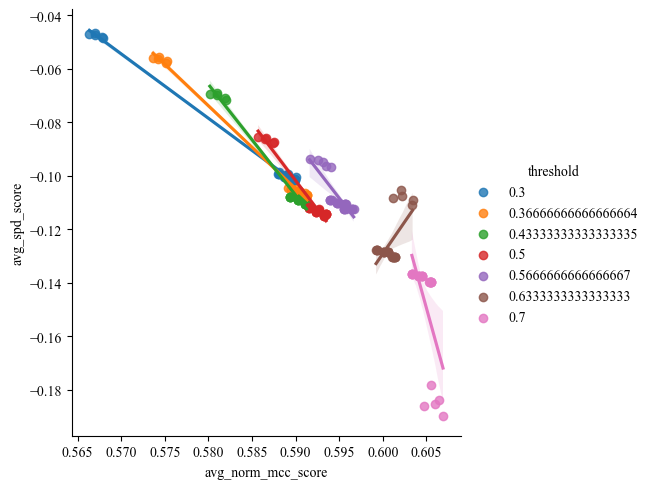

In [66]:
# import matplotlib.pyplot as plt
# results_NB.plot(x="avg_norm_mcc_score", y="avg_spd_score", kind="scatter")
# plt.show()
g = sns.lmplot(data=results_NB, x="avg_norm_mcc_score", y="avg_spd_score", hue="threshold")

In [31]:
results_dict = {}
results_dict['results_LR'] = results_LR
results_dict['results_RF'] = results_RF
results_dict['results_GB'] = results_GB
results_dict['results_SVM'] = results_SVM
results_dict['results_NB'] = results_NB

In [33]:
results_all = pd.concat(results_dict.values())
results_all.to_pickle('Compas_results_all')
results_all

model                                             param Bias_Mitigation  \
0      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
1      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
2      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
3      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
4      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
..    ...                                               ...             ...   
170    NB                          {'var_smoothing': 1e-09}             CEO   
171    NB                          {'var_smoothing': 1e-09}             CEO   
172    NB                          {'var_smoothing': 1e-09}             CEO   
173    NB                          {'var_smoothing': 1e-09}             CEO   
174    NB                          {'var_smoothing': 1e-09}             CEO   

     threshold  avg_acc_score  avg_bacc_score  avg_f1_score  avg_auc_score  \
0     0.300000       0.583028        0.556393      0.709051       0.664417   
1     0.366667       0.600432        0.576799      0.712868       0.663874   
2     0.433333       0.615803        0.596442      0.711322       0.662518   
3     0.500000       0.627922        0.614685      0.700129       0.661027   
4     0.566667       0.616565        0.612523      0.651076       0.661212   
..         ...            ...             ...           ...            ...   
170   0.433333       0.592163        0.567482      0.709714       0.645454   
171   0.500000       0.594504        0.570195      0.710306       0.645437   
172   0.566667       0.594276        0.573351      0.698722       0.645436   
173   0.633333       0.589724        0.580359      0.573304       0.645437   
174   0.700000       0.594959        0.586626      0.574110       0.645447   

     avg_mcc_score  avg_norm_mcc_score  avg_spd_score  avg_aod_score  \
0         0.175553            0.587777      -0.054229      -0.043724   
1         0.203772            0.601886      -0.063242      -0.047741   
2         0.222882            0.611441      -0.071096      -0.051633   
3         0.238951            0.619475      -0.085383      -0.062144   
4         0.228038            0.614019      -0.088668      -0.066210   
..             ...                 ...            ...            ...   
170       0.182166            0.591083      -0.110796      -0.100410   
171       0.186505            0.593252      -0.115187      -0.104569   
172       0.191209            0.595605      -0.112410      -0.102150   
173       0.202260            0.601130      -0.130535      -0.117973   
174       0.210765            0.605382      -0.139806      -0.125796   

     avg_eod_score  avg_ford_score  avg_ppvd_score      cost  
0        -0.023771       -0.047150       -0.105152  0.357995  
1        -0.027745       -0.053971       -0.101894  0.334871  
2        -0.026020       -0.075768       -0.092990  0.317463  
3        -0.031332       -0.096949       -0.076066  0.295141  
4        -0.033541       -0.136610       -0.054402  0.297313  
..             ...             ...             ...       ...  
170      -0.062487       -0.043203       -0.091798  0.298121  
171      -0.063953       -0.046874       -0.089449  0.291561  
172      -0.051424       -0.084700       -0.081900  0.291985  
173      -0.074823       -0.060432       -0.060378  0.268334  
174      -0.083345       -0.052693       -0.058093  0.254811  

[1267 rows x 16 columns]

In [93]:
results_all = pd.read_pickle('Compas_results_all')
results_all

model                                             param Bias_Mitigation  \
0      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
1      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
2      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
3      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
4      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
..    ...                                               ...             ...   
170    NB                          {'var_smoothing': 1e-09}             CEO   
171    NB                          {'var_smoothing': 1e-09}             CEO   
172    NB                          {'var_smoothing': 1e-09}             CEO   
173    NB                          {'var_smoothing': 1e-09}             CEO   
174    NB                          {'var_smoothing': 1e-09}             CEO   

     threshold  avg_acc_score  avg_bacc_score  avg_f1_score  avg_auc_score  \
0     0.300000       0.583028        0.556393      0.709051       0.664417   
1     0.366667       0.600432        0.576799      0.712868       0.663874   
2     0.433333       0.615803        0.596442      0.711322       0.662518   
3     0.500000       0.627922        0.614685      0.700129       0.661027   
4     0.566667       0.616565        0.612523      0.651076       0.661212   
..         ...            ...             ...           ...            ...   
170   0.433333       0.592163        0.567482      0.709714       0.645454   
171   0.500000       0.594504        0.570195      0.710306       0.645437   
172   0.566667       0.594276        0.573351      0.698722       0.645436   
173   0.633333       0.589724        0.580359      0.573304       0.645437   
174   0.700000       0.594959        0.586626      0.574110       0.645447   

     avg_mcc_score  avg_norm_mcc_score  avg_spd_score  avg_aod_score  \
0         0.175553            0.587777      -0.054229      -0.043724   
1         0.203772            0.601886      -0.063242      -0.047741   
2         0.222882            0.611441      -0.071096      -0.051633   
3         0.238951            0.619475      -0.085383      -0.062144   
4         0.228038            0.614019      -0.088668      -0.066210   
..             ...                 ...            ...            ...   
170       0.182166            0.591083      -0.110796      -0.100410   
171       0.186505            0.593252      -0.115187      -0.104569   
172       0.191209            0.595605      -0.112410      -0.102150   
173       0.202260            0.601130      -0.130535      -0.117973   
174       0.210765            0.605382      -0.139806      -0.125796   

     avg_eod_score  avg_ford_score  avg_ppvd_score      cost  
0        -0.023771       -0.047150       -0.105152  0.357995  
1        -0.027745       -0.053971       -0.101894  0.334871  
2        -0.026020       -0.075768       -0.092990  0.317463  
3        -0.031332       -0.096949       -0.076066  0.295141  
4        -0.033541       -0.136610       -0.054402  0.297313  
..             ...             ...             ...       ...  
170      -0.062487       -0.043203       -0.091798  0.298121  
171      -0.063953       -0.046874       -0.089449  0.291561  
172      -0.051424       -0.084700       -0.081900  0.291985  
173      -0.074823       -0.060432       -0.060378  0.268334  
174      -0.083345       -0.052693       -0.058093  0.254811  

[1267 rows x 16 columns]

In [35]:
import seaborn as sns

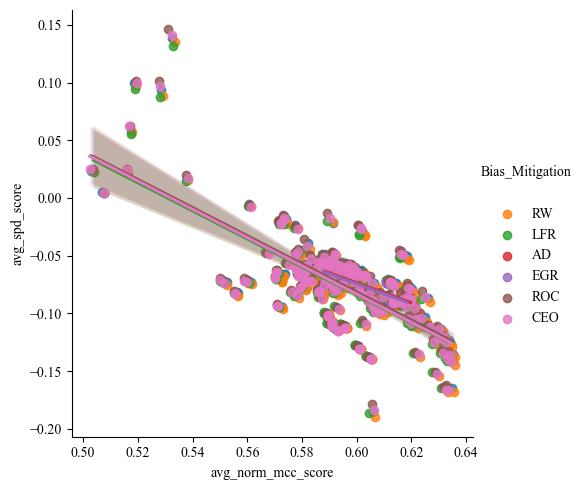

In [92]:
g = sns.lmplot(data=data, x="avg_norm_mcc_score", y="avg_spd_score", hue='Bias_Mitigation')
# g.ax.axline(xy1=(10, 2), slope=.2, color="b", dashes=(5, 2))

In [74]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

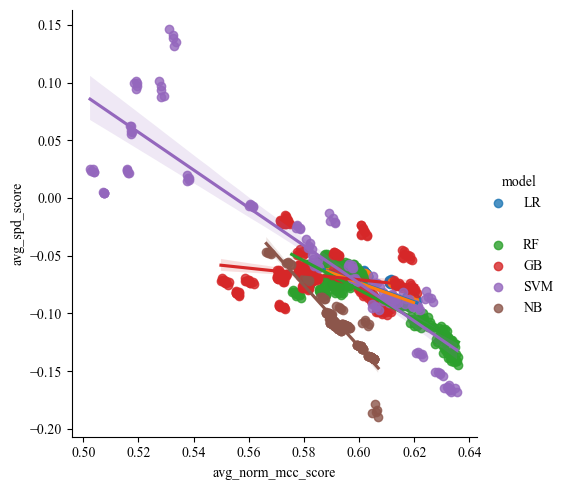

In [76]:
# g = sns.lmplot(data=results_all, x="avg_norm_mcc_score", y="avg_spd_score", 
#                hue='model', col='Bias_Mitigation', row='threshold')
slope, intercept, r_value, pv, se = stats.linregress(roll_new['Yield'], roll_new['Onboarded'])
sns.regplot(roll_new['Yield'], roll_new['Onboarded'], line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
plt.xticks(fontsize=15)
plt.legend()
plt.yticks(fontsize=15)
g = sns.lmplot(data=results_all, x="avg_norm_mcc_score", y="avg_spd_score", hue='model')

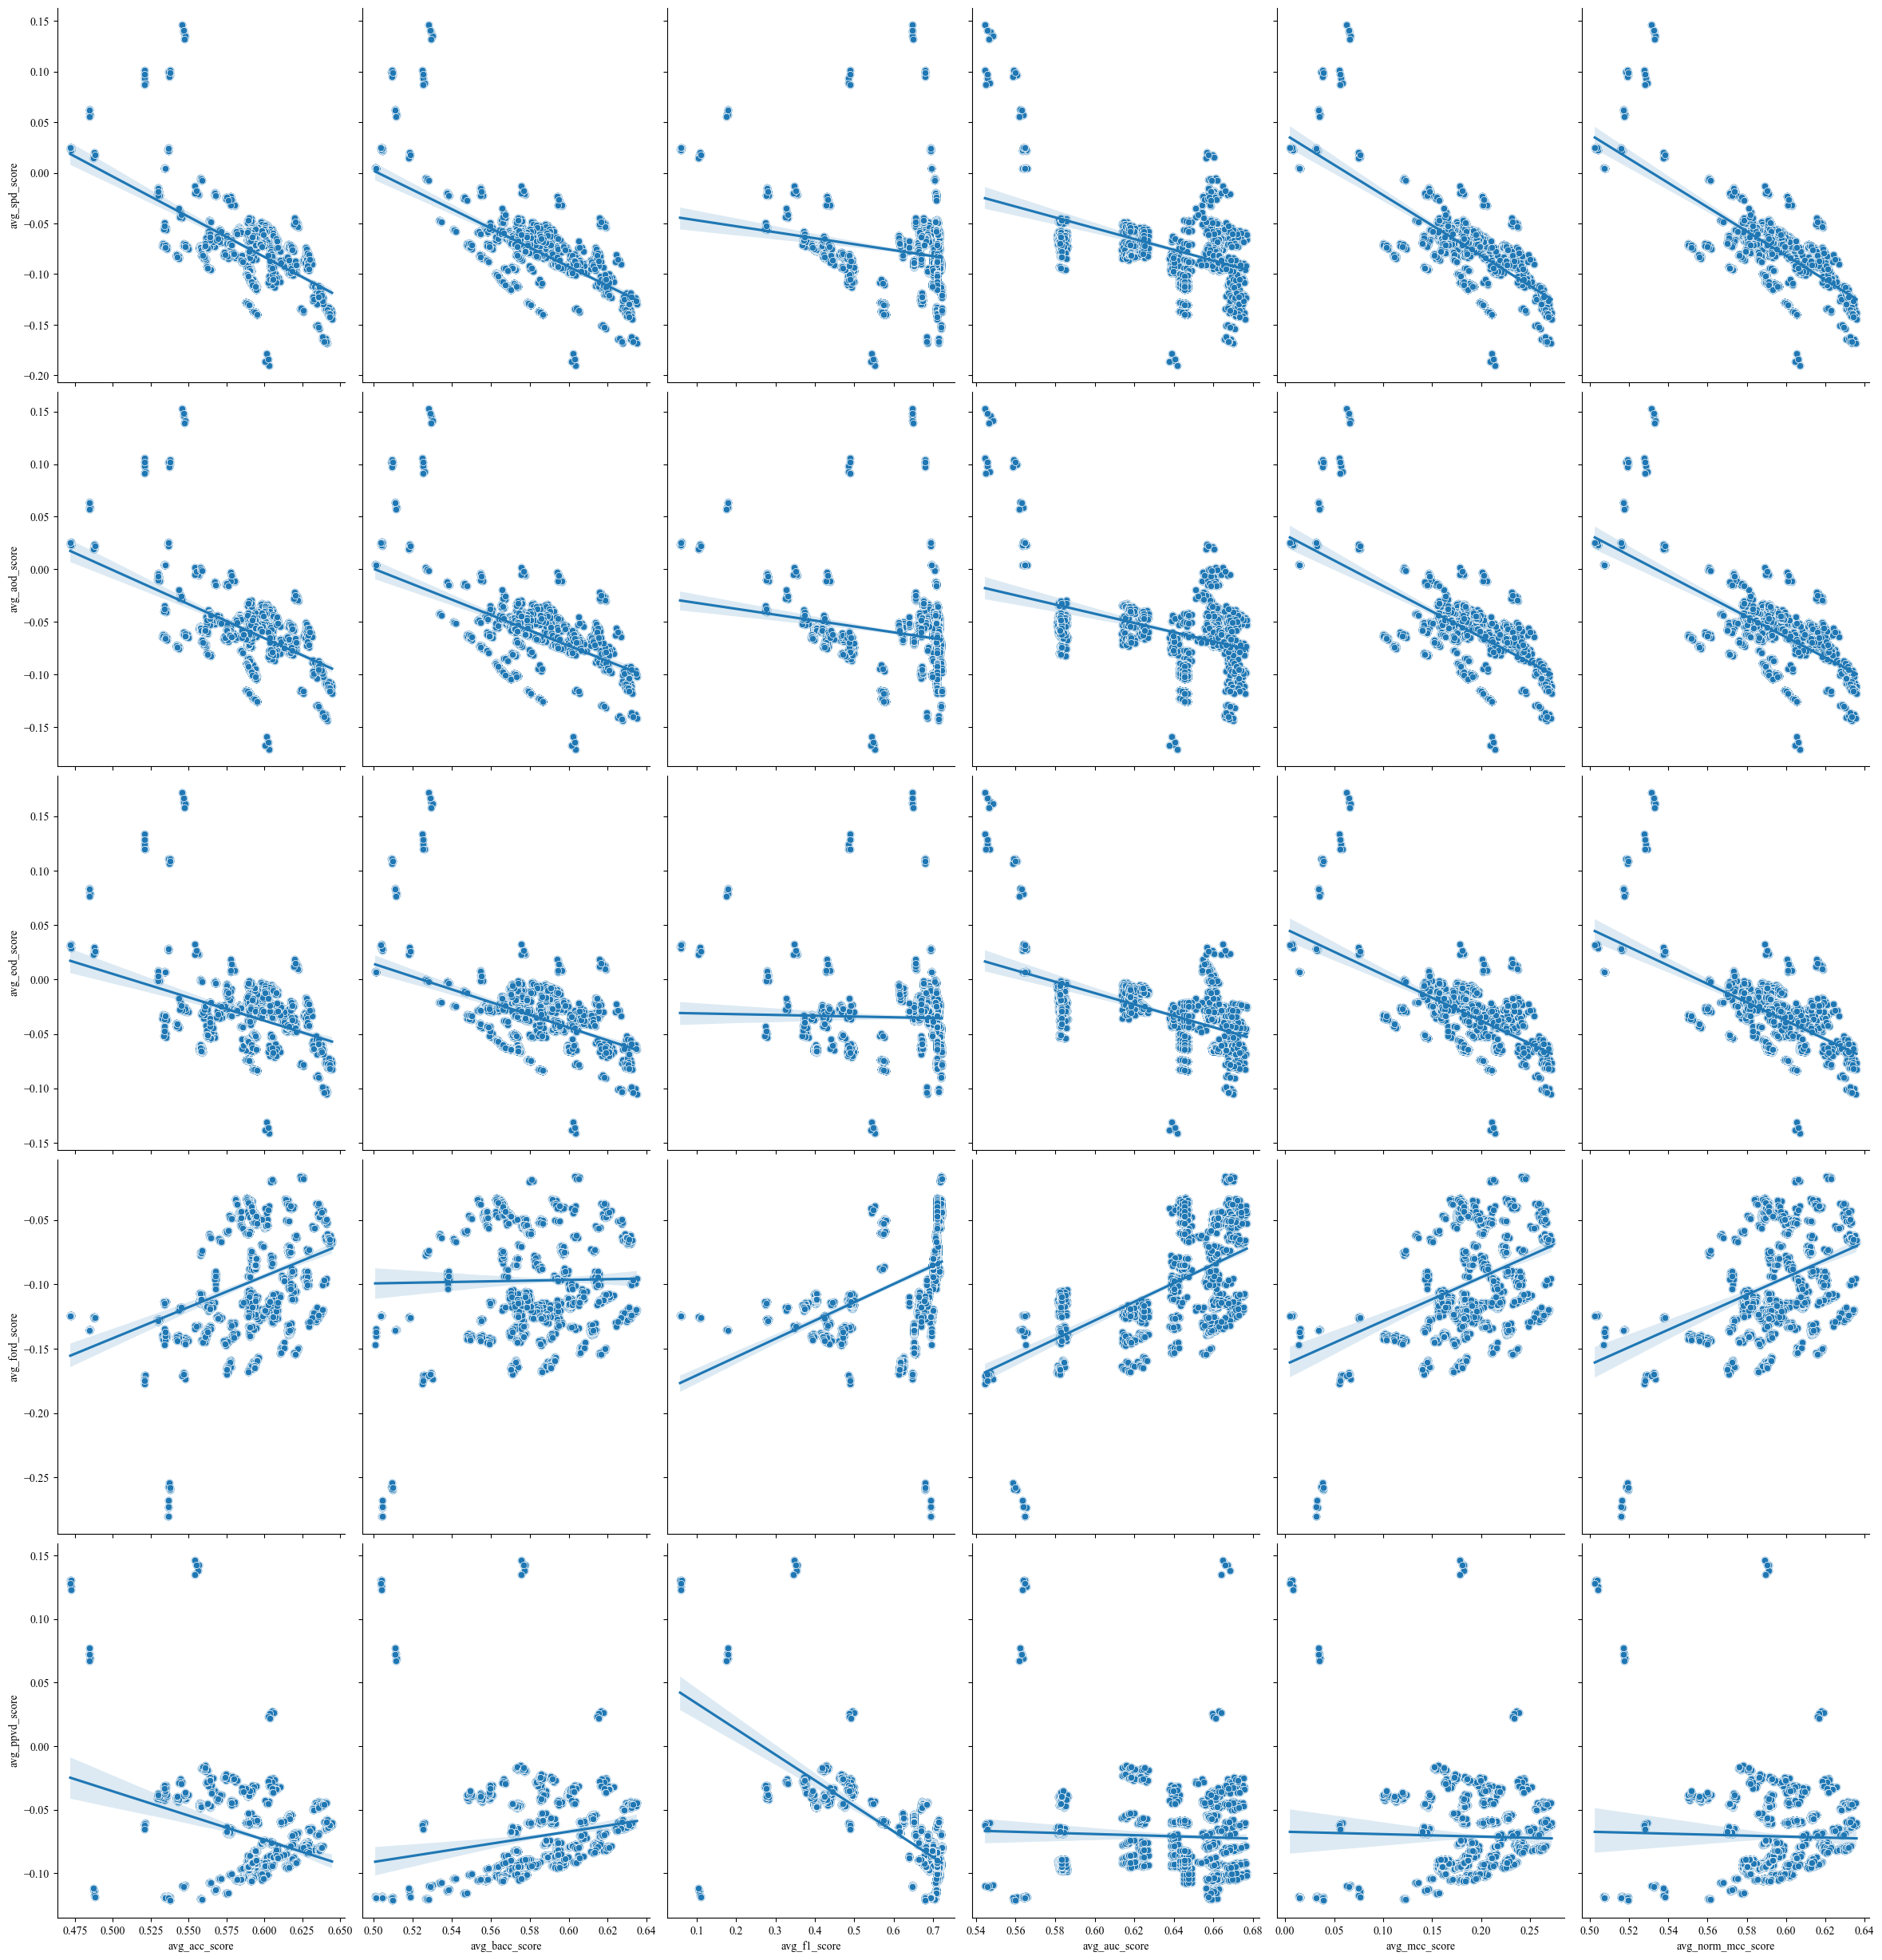

In [73]:
accuracy_metrics = ['avg_'+col for col in ['acc_score', 'bacc_score', 'f1_score', 'auc_score', 'mcc_score','norm_mcc_score']]
fairness_metrics = ['avg_'+col for col in ['spd_score', 'aod_score', 'eod_score','ford_score','ppvd_score']]
g = sns.pairplot(data=results_all, x_vars=accuracy_metrics, y_vars=fairness_metrics,
             height=5, aspect=.8, kind="reg")
g.map(sns.scatterplot)

In [82]:
results_all_converted = results_all.copy(deep=True)
for col in fairness_metrics:
    abs_col_name = 'abs_'+col
    results_all_converted[abs_col_name] = results_all_converted[col].abs()
results_all_converted

model                                             param Bias_Mitigation  \
0      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
1      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
2      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
3      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
4      LR  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}                   
..    ...                                               ...             ...   
170    NB                          {'var_smoothing': 1e-09}             CEO   
171    NB                          {'var_smoothing': 1e-09}             CEO   
172    NB                          {'var_smoothing': 1e-09}             CEO   
173    NB                          {'var_smoothing': 1e-09}             CEO   
174    NB                          {'var_smoothing': 1e-09}             CEO   

     threshold  avg_acc_score  avg_bacc_score  avg_f1_score  avg_auc_score  \
0     0.300000       0.583028        0.556393      0.709051       0.664417   
1     0.366667       0.600432        0.576799      0.712868       0.663874   
2     0.433333       0.615803        0.596442      0.711322       0.662518   
3     0.500000       0.627922        0.614685      0.700129       0.661027   
4     0.566667       0.616565        0.612523      0.651076       0.661212   
..         ...            ...             ...           ...            ...   
170   0.433333       0.592163        0.567482      0.709714       0.645454   
171   0.500000       0.594504        0.570195      0.710306       0.645437   
172   0.566667       0.594276        0.573351      0.698722       0.645436   
173   0.633333       0.589724        0.580359      0.573304       0.645437   
174   0.700000       0.594959        0.586626      0.574110       0.645447   

     avg_mcc_score  avg_norm_mcc_score  avg_spd_score  avg_aod_score  \
0         0.175553            0.587777      -0.054229      -0.043724   
1         0.203772            0.601886      -0.063242      -0.047741   
2         0.222882            0.611441      -0.071096      -0.051633   
3         0.238951            0.619475      -0.085383      -0.062144   
4         0.228038            0.614019      -0.088668      -0.066210   
..             ...                 ...            ...            ...   
170       0.182166            0.591083      -0.110796      -0.100410   
171       0.186505            0.593252      -0.115187      -0.104569   
172       0.191209            0.595605      -0.112410      -0.102150   
173       0.202260            0.601130      -0.130535      -0.117973   
174       0.210765            0.605382      -0.139806      -0.125796   

     avg_eod_score  avg_ford_score  avg_ppvd_score      cost  \
0        -0.023771       -0.047150       -0.105152  0.357995   
1        -0.027745       -0.053971       -0.101894  0.334871   
2        -0.026020       -0.075768       -0.092990  0.317463   
3        -0.031332       -0.096949       -0.076066  0.295141   
4        -0.033541       -0.136610       -0.054402  0.297313   
..             ...             ...             ...       ...   
170      -0.062487       -0.043203       -0.091798  0.298121   
171      -0.063953       -0.046874       -0.089449  0.291561   
172      -0.051424       -0.084700       -0.081900  0.291985   
173      -0.074823       -0.060432       -0.060378  0.268334   
174      -0.083345       -0.052693       -0.058093  0.254811   

     abs_avg_spd_score  abs_avg_aod_score  abs_avg_eod_score  \
0             0.054229           0.043724           0.023771   
1             0.063242           0.047741           0.027745   
2             0.071096           0.051633           0.026020   
3             0.085383           0.062144           0.031332   
4             0.088668           0.066210           0.033541   
..                 ...                ...                ...   
170           0.110796           0.1

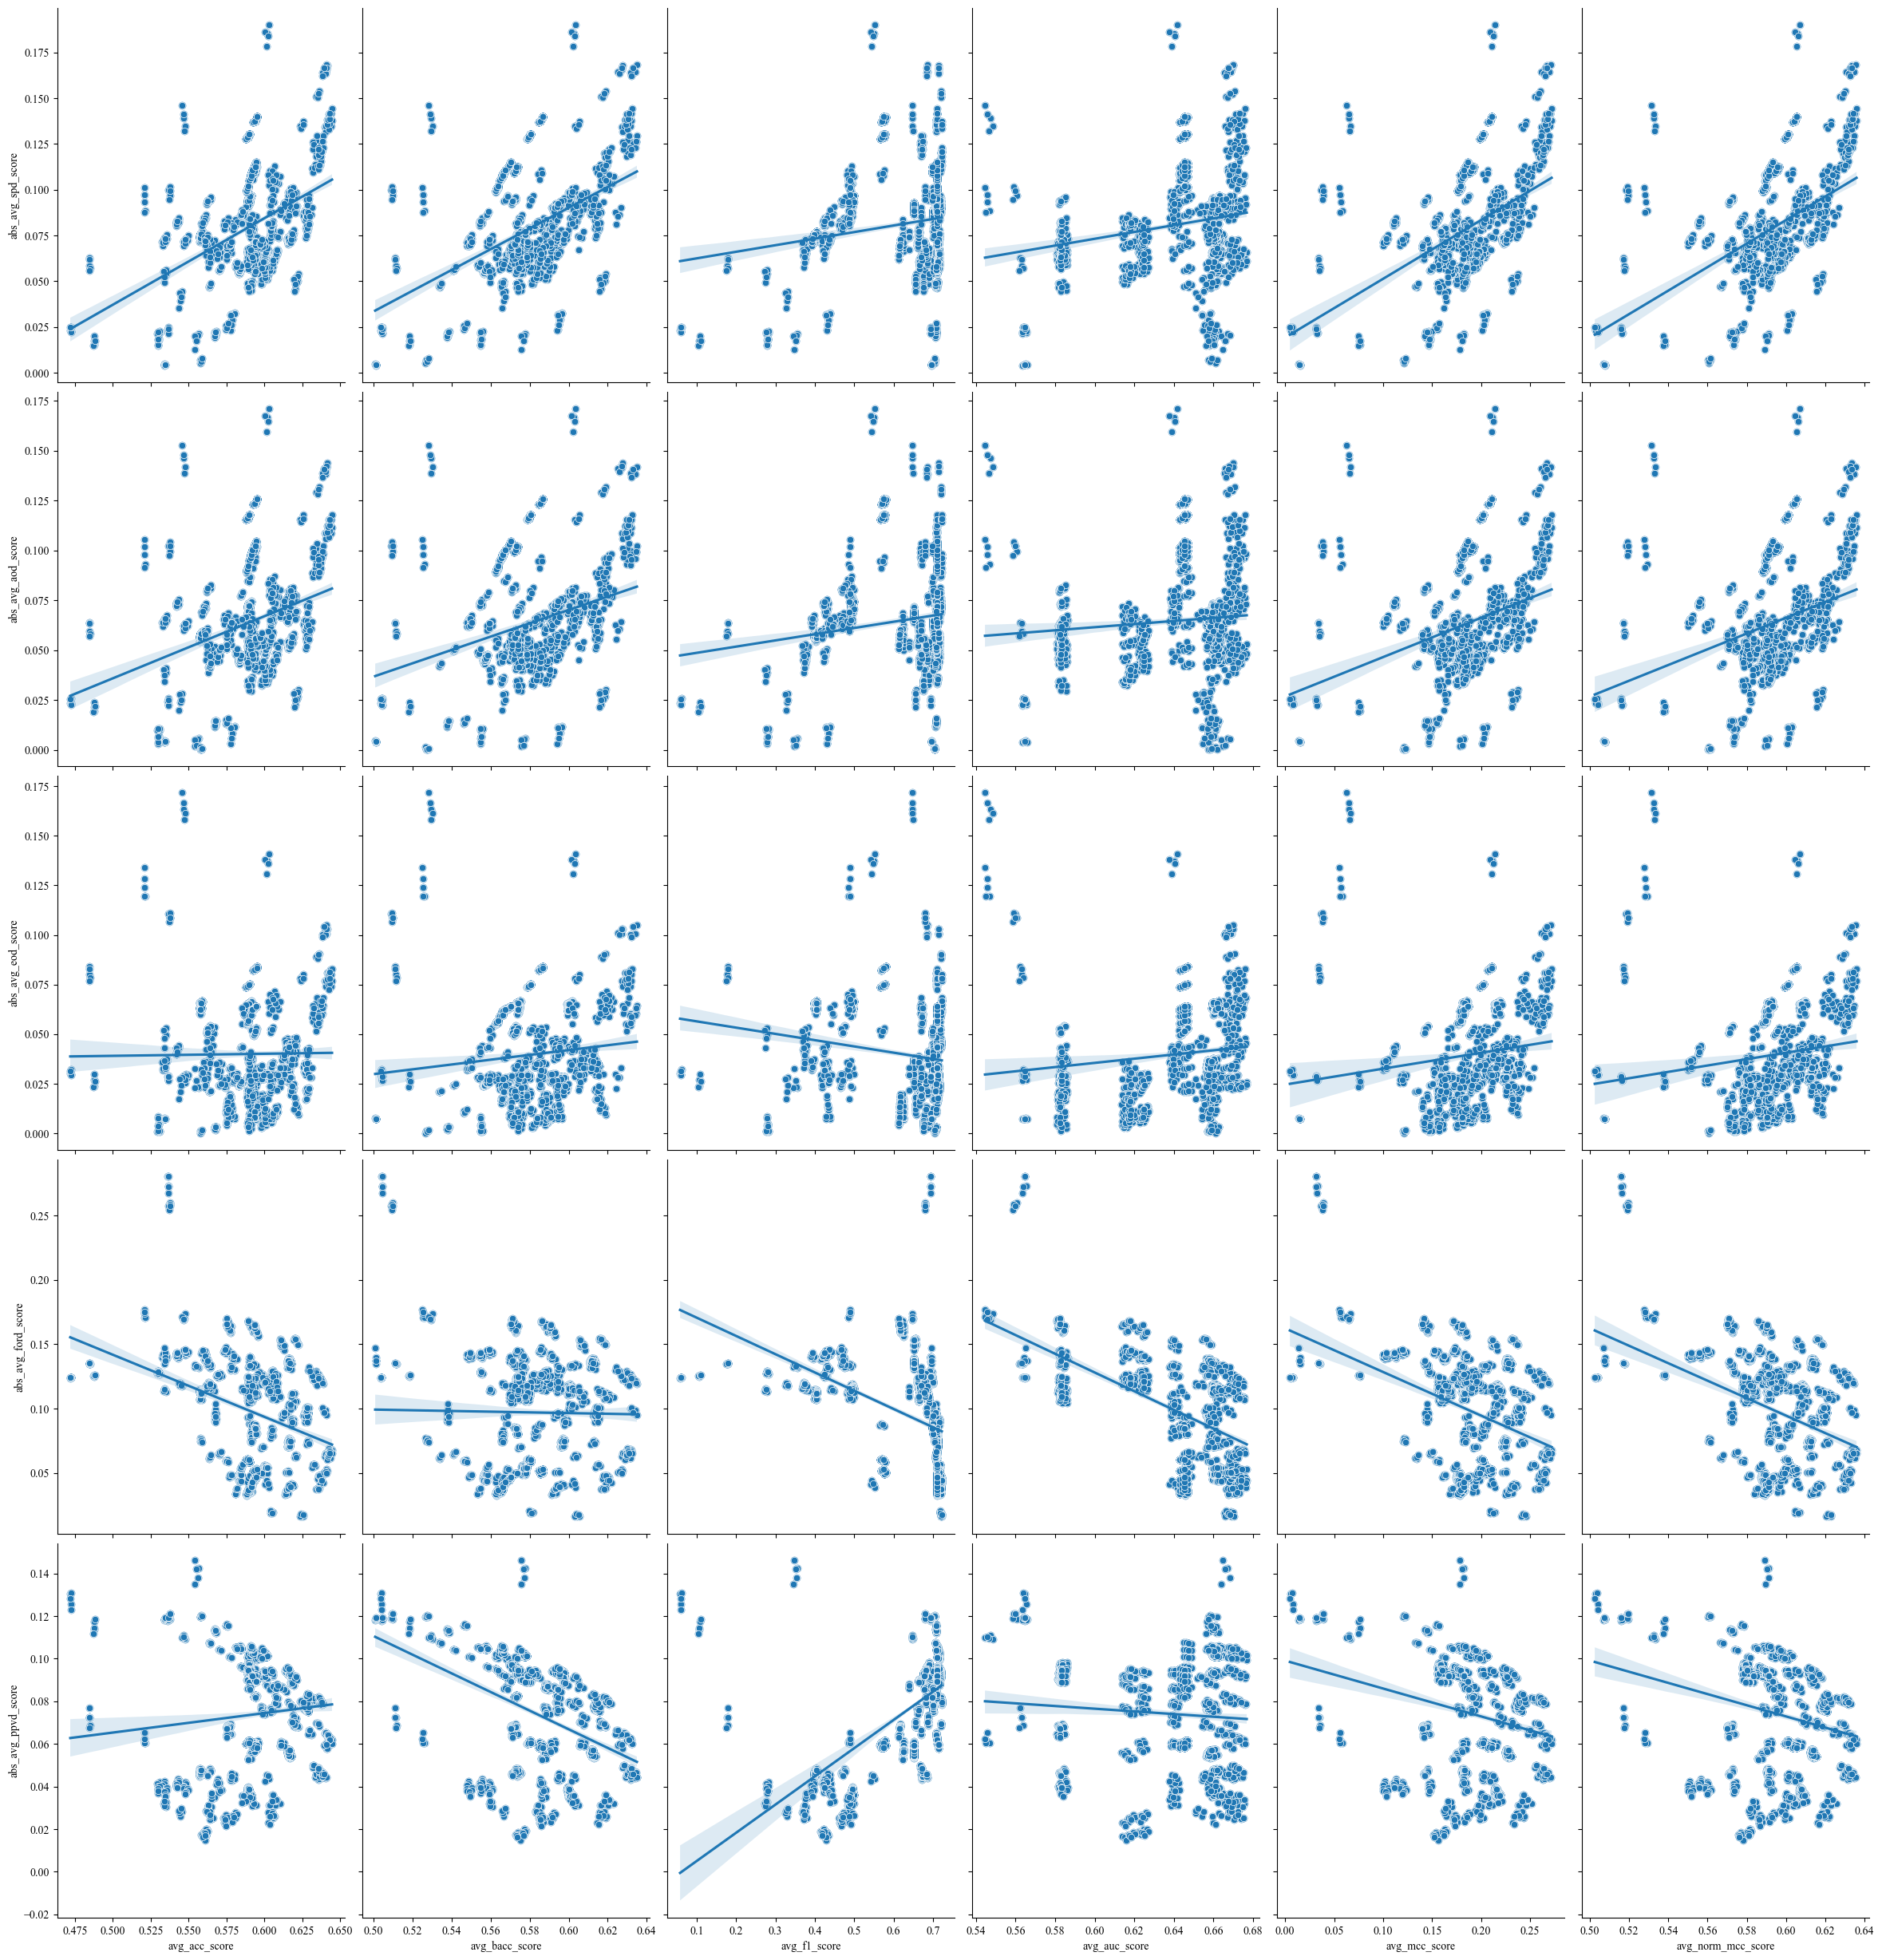

In [85]:
accuracy_metrics = ['avg_'+col for col in ['acc_score', 'bacc_score', 'f1_score', 'auc_score', 'mcc_score','norm_mcc_score']]
fairness_metrics = ['avg_'+col for col in ['spd_score', 'aod_score', 'eod_score','ford_score','ppvd_score']]
abs_fairness_metrics = ['abs_'+col for col in fairness_metrics]
g = sns.pairplot(data=results_all_converted, x_vars=accuracy_metrics, y_vars=abs_fairness_metrics,
             height=5, aspect=.8, kind="reg")
g.map(sns.scatterplot)